In [1]:
import numpy as np
import matplotlib.pyplot as plt
from numpy import linalg as la
from enum import Enum
from typing import List, Union
import ipywidgets as widgets

import time
import random
import math
from scipy.spatial import ConvexHull

from shapely.geometry import Polygon

# Implementation of GJK

## Simplex structure

We use this structure not to consider the whole Minkowski Difference

In [2]:
class SimplexType(Enum):
    Zero = 0
    Point = 1
    Line = 2
    Triangle = 3

class Simplex:
    def __init__(self, points: np.array = None):
        self._points = [] if points is None else points

    def push_front(self, point: np.array):        
        self._points = np.array([point, *self._points])
                
        if self.size() > 3:
            self._points = np.array([self._points[0], self._points[1], self._points[2]])

    def __getitem__(self, i: int) -> np.array:
        return self._points[i]

    def size(self) -> int:
        return len(self._points)

    def __iter__(self):
        return iter(self._points)

    def type(self) -> SimplexType:
        return SimplexType(self.size())
    
    def __str__(self):
        res = "["
        for p in self._points:
            res += str(p) + " "    
        res += "]"
        
        return res

In [321]:
def normal_of_vector(vec: np.array) -> np.array:    
    return np.array([-vec[1], vec[0]])/la.norm(vec)

## Body structure

In [3]:
class Body:
    def __init__(self, hitBox: np.ndarray = None):
        self.points = [] if hitBox is None else hitBox
    
    def draw(self):
        x_list = self.points[:, 0]
        y_list = self.points[:, 1]
        
        # add the first point to close the figure
        x_list = np.append(x_list, x_list[0])
        y_list = np.append(y_list, y_list[0])
        
        plt.fill_between(x_list, y_list, alpha=0.2)
        plt.plot(x_list, y_list)
        
        return x_list, y_list
    
    @staticmethod
    def draw_several(shapes):
        for shape in shapes:
            shape.draw()
    
    def size(self) -> int:
        return len(self.points)
    
    # GJK part
    def _find_furthest_point(self, direction):
        max_point = self.points[np.argmax(self.points@direction)]
        return max_point

    def _support(self, obj, direction):
        p1 = self._find_furthest_point(direction)
        p2 = obj._find_furthest_point(-direction)

        return p1 - p2
        
    @staticmethod
    def _next_simplex(simplex):
        simplex_type = simplex.type()

        if simplex_type == SimplexType.Line:
            return Body._line_case(simplex)
        elif simplex_type == SimplexType.Triangle:
            return Body._triangle_case(simplex)
        else:
            raise ValueError("Body::next_simplex: simplex is not Line or Triangle")

    @staticmethod
    def _line_case(simplex):
        
        new_simplex = simplex
        new_direction = 0

        a = simplex[0]
        b = simplex[1]

        ab = b - a
        ao = -a
        
        ab_n = normal_of_vector(ab)

        if ab@ao > 0:
            new_direction = ab_n if ab_n@ao > 0 else -ab_n
        else:
            new_simplex = Simplex([a])
            new_direction = ao

        return new_simplex, new_direction, False

    @staticmethod
    def _triangle_case(simplex):
                
        new_simplex = simplex
        new_direction = np.array([])

        a = simplex[0]
        b = simplex[1]
        c = simplex[2]

        ab = b - a
        ac = c - a
        ao = -a
        
        ac_n = normal_of_vector(ac)

        if ac_n@ao > 0:
            if ac@ao > 0:
                new_simplex = Simplex([a, c])
                new_direction = ac_n
            else:
                return Body._line_case(Simplex([a, b]))
        else:
            if normal_of_vector(ab)@ao < 0:
                # here we need to reverse the order because we can find the next
                # point only in the direction of the -normal of AB
                return Body._line_case(Simplex([b, a]))
            else:
                # Collision detected
                return new_simplex, new_direction, True
        
        return new_simplex, new_direction, False

    def check_collision_gjk(self, obj):
        
        # Get initial support point in any direction
        support = self._support(obj, np.array([1, 0]))

        # Simplex is an array of points, max count is 4
        simplex = Simplex()
        simplex.push_front(support)

        # New direction is towards the origin
        direction = -support

        iters = 0
        while iters < self.size() + obj.size():
            iters += 1
            support = self._support(obj, direction)

            if support@direction <= 0:
                return False, simplex  # no collision

            simplex.push_front(support)

            new_simplex, new_direction, is_found = Body._next_simplex(simplex)

            direction = new_direction
            simplex = new_simplex
            
            if is_found:
                return True, simplex
        

        return False, simplex

In [4]:
def test_collision(x_shift=2.40, y_shift=-0.30):
    body2 = Body(np.array([[-1+x_shift, -1+y_shift ], [0+x_shift, 1+y_shift], [1+x_shift, -1+y_shift]]))
    body1 = Body(np.array([[-1        , -1         ], [0        ,         1], [1        ,          1],  [2, -1]]))
    
    plt.xlim(-10, 10)
    plt.ylim(-10, 10)
    Body.draw_several([body1, body2])
    
    is_collision, _ = body1.check_collision_gjk(body2)
    print("Collision =", is_collision)

In [63]:
# simple example with trangle and parallelogram 
widgets.interact(test_collision, x_shift=(-3.0, 3.0, 0.3), y_shift=(-3.0, 3.0, 0.3))

interactive(children=(FloatSlider(value=2.4, description='x_shift', max=3.0, min=-3.0, step=0.3), FloatSlider(…

<function __main__.test_collision(x_shift=2.4, y_shift=-0.3)>

## Generator of random convex shapes

In [12]:
def generate_random_convex_shape(num_points, plot=False):
    # Ensure num_points is at least 3 for a valid convex hull
    num_points = max(3, num_points)
    
    # Generate random points    
    points = (np.random.rand(num_points, 2) - 0.5)*2*5
    
    # Compute the convex hull
    hull = ConvexHull(points)
        
    if len(hull.vertices) < num_points:
        # we need more points to generate convex shape:
        while len(hull.vertices) < num_points:            
            new_points = np.concatenate((points, (np.random.rand(1, 2) - 0.5)*2*10))
            new_hull = ConvexHull(new_points)
            
            if len(new_hull.vertices) > len(hull.vertices):
                hull = new_hull
                points = new_points
    
    pos = (2*np.random.rand(1, 2) - 1)*num_points
    points = points[hull.vertices] + pos
    
    # Plot the convex shape
    if plot:
        plt.xlim(-10, 10)
        plt.ylim(-10, 10)
        
        x_list = [v[0] for v in points]
        y_list = [v[1] for v in points]
        # add the first point to close the figure
        x_list.append(points[0, 0])
        y_list.append(points[0, 1])
        plt.plot(x_list, y_list, marker = 'o')

        plt.gca().set_aspect('equal', adjustable='box')  # Equal aspect ratio
        plt.show()
    
    return points

In [13]:
def test_collision(points1=10, points2=10, pos1x=0.0, pos1y=0.0, seed=300):
    np.random.seed(seed)
    
    v1 = generate_random_convex_shape(points1) + np.array([pos1x, pos1y])
    v2 = generate_random_convex_shape(points2)
    
    body2 = Body(v1)
    body1 = Body(v2)
    
    p1 = Polygon(v1)
    p2 = Polygon(v2)
    
    plt.xlim(-20, 20)
    plt.ylim(-20, 20)
    Body.draw_several([body1, body2])
    
    is_collision, _ = body1.check_collision_gjk(body2)
    print("GJK answer =", is_collision)
    print("shapely answer =", p1.intersects(p2))

In [14]:
# interactive example

widgets.interact(test_collision, 
                 points1=(3, 10, 1),
                 points2=(3, 10, 1), 
                 pos1x=(-10, 10, 0.1), 
                 pos1y=(-10, 10, 0.1),
                 seed=(0, 1000, 100))
                 

interactive(children=(IntSlider(value=10, description='points1', max=10, min=3), IntSlider(value=10, descripti…

<function __main__.test_collision(points1=10, points2=10, pos1x=0.0, pos1y=0.0, seed=300)>

## Test with many random shapes

In [79]:
def testGJK(seed=211, min_points=3, max_points=10, iterations_per_numbers=1000):
    np.random.seed(seed)
    
    yes = []
    no = []
    incorrect = []
    correct = []
    
    for points1 in range(min_points, max_points+1):
        for points2 in range(min_points, max_points+1):
            for i in range(iterations_per_numbers):
                
                v1 = generate_random_convex_shape(points1)
                v2 = generate_random_convex_shape(points2)
    
                body1 = Body(v1)
                body2 = Body(v2)
    
                p1 = Polygon(v1)
                p2 = Polygon(v2)
            
                intersects = p1.intersects(p2)
                
                if intersects:
                    yes.append([v1, v2])
                else:
                    no.append([v1, v2])
                    
                is_collision, _ = body1.check_collision_gjk(body2)
                
                if is_collision == intersects:
                    correct.append([v1, v2])
                else:
                    incorrect.append([v1, v2])
            
            w = max_points+1-min_points
            h = w
            print("progress:", 100*((points1-min_points)*w + points2-min_points)/(w*h), end="\r")
    
    return correct, incorrect, yes, no

In [80]:
correct, incorrect, yes, no = testGJK()

In [81]:
print("correct:", len(correct))
print("incorrect:", len(incorrect))
print("yes:", len(yes))
print("no:", len(no))

correct: 64000
incorrect: 0
yes: 34610
no: 29390


## Examples of intersections

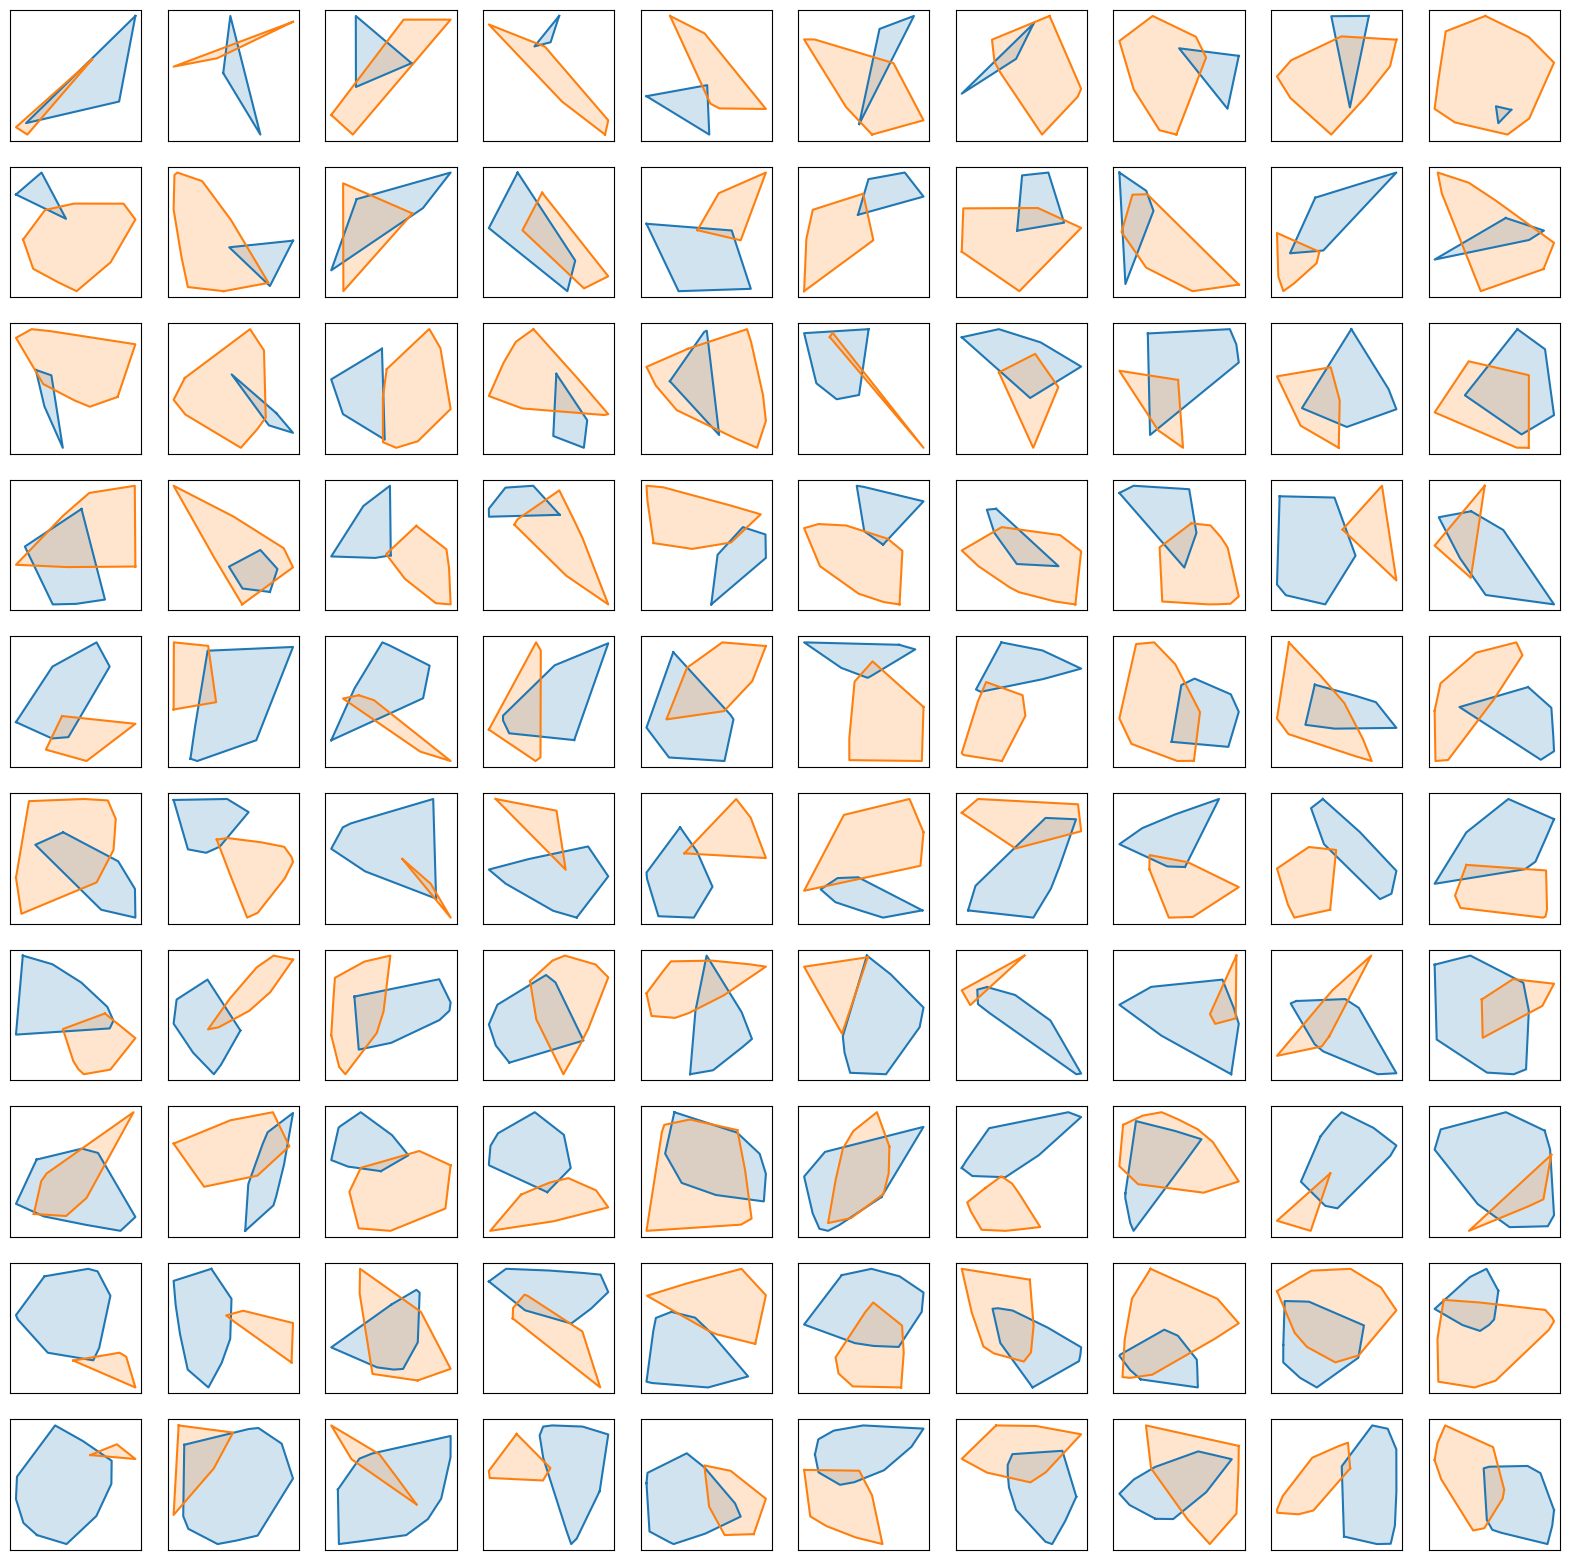

In [82]:
plt.figure(figsize=(20,20))

for i in range(100):
    
    plt.subplot(10, 10, i+1)
    
    el = int(i*len(yes)/100)
    Body.draw_several([Body(yes[el][0]), Body(yes[el][1])])
    plt.xticks([])
    plt.yticks([])

plt.savefig("plots/rand_inters.pdf", format="pdf", bbox_inches="tight")
plt.show()

## Examples of no intersections

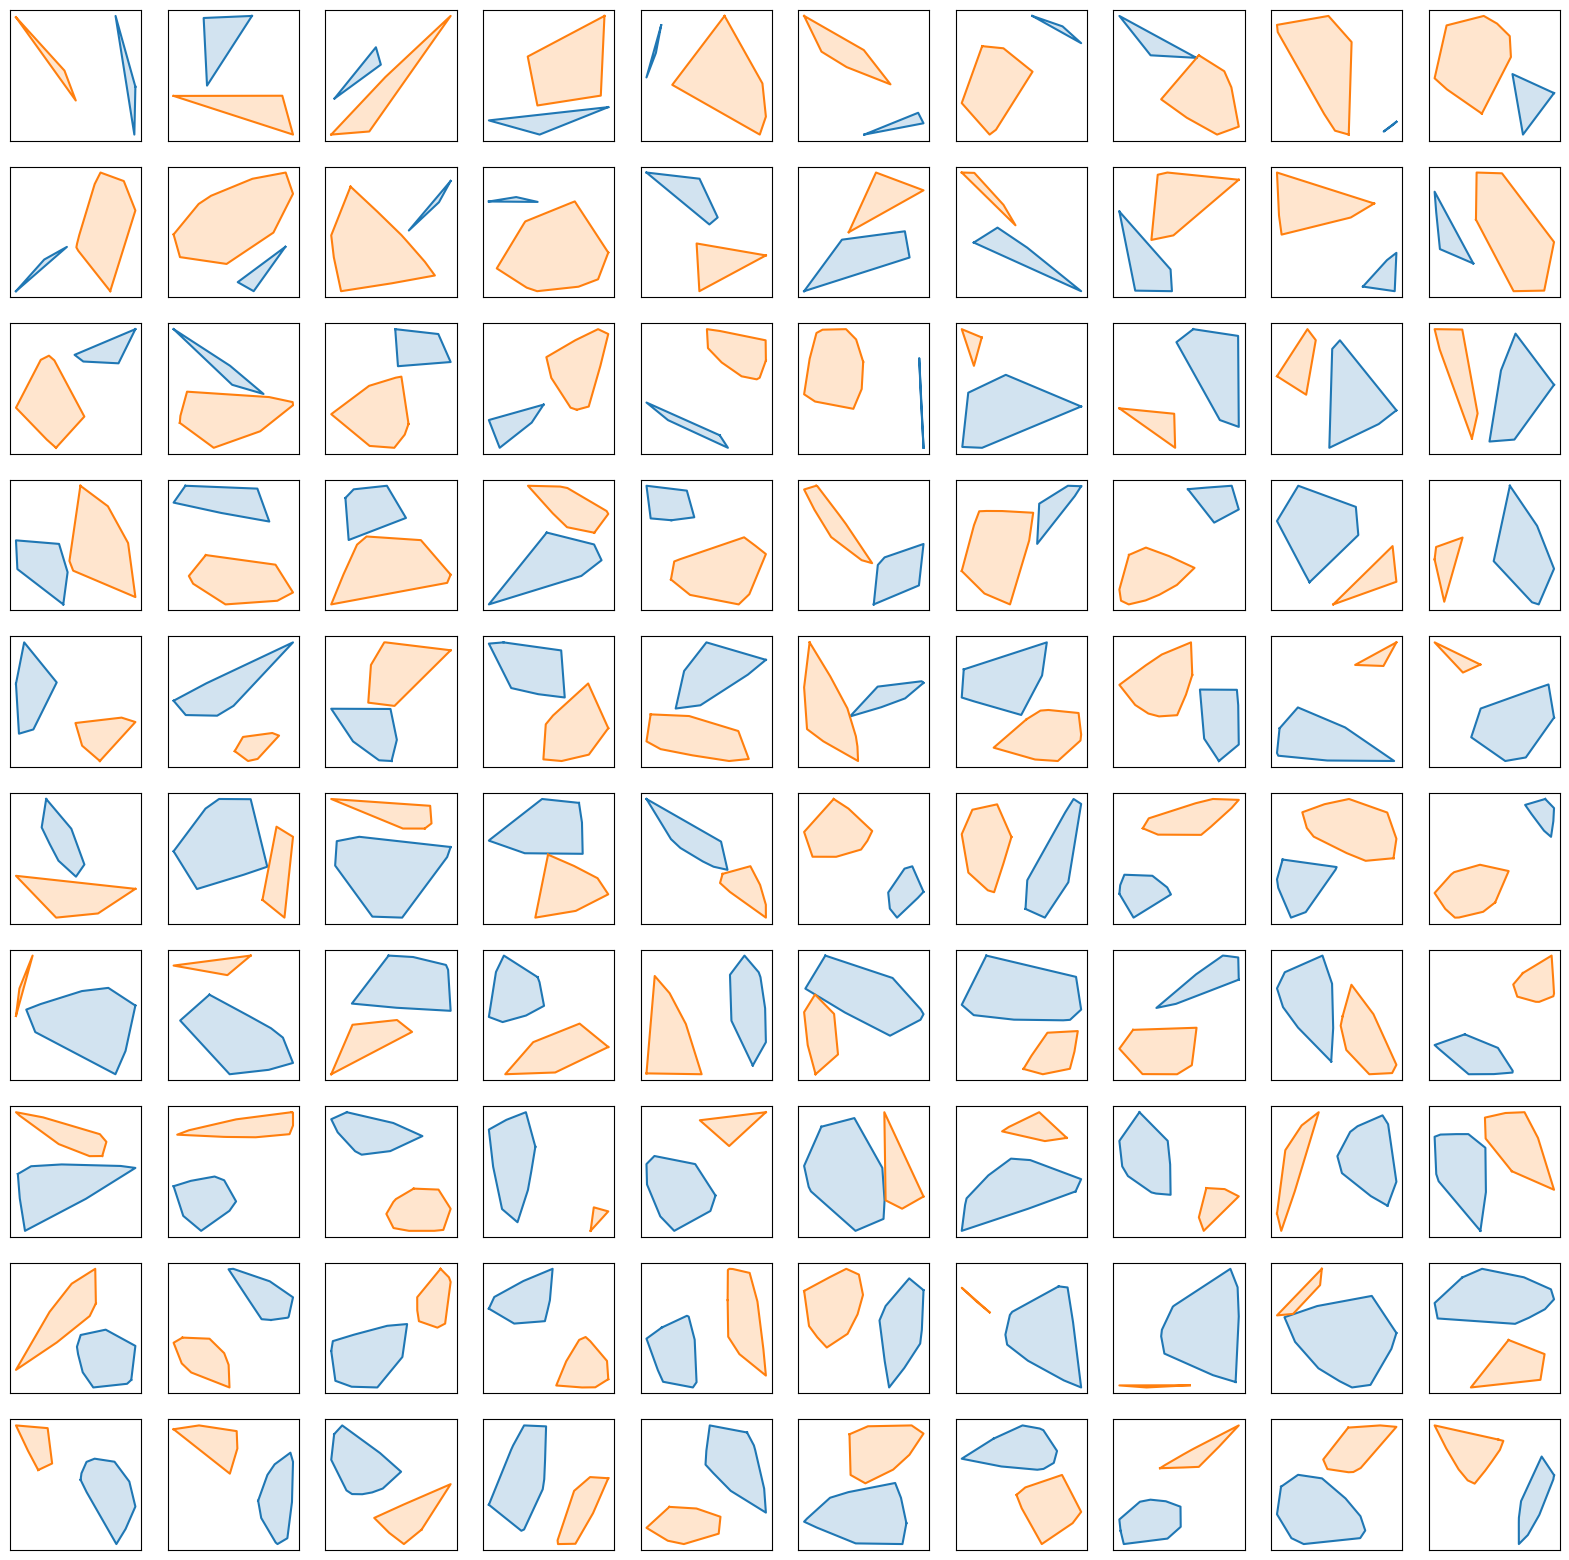

In [83]:
plt.figure(figsize=(20,20))

for i in range(100):
    
    plt.subplot(10, 10, i+1)
    
    el = int(i*len(no)/100)
    Body.draw_several([Body(no[el][0]), Body(no[el][1])])
    plt.xticks([])
    plt.yticks([])

plt.savefig("plots/rand_no_inters.pdf", format="pdf", bbox_inches="tight")
plt.show()

## Generator of random Regular polygons with random size, position and rotation

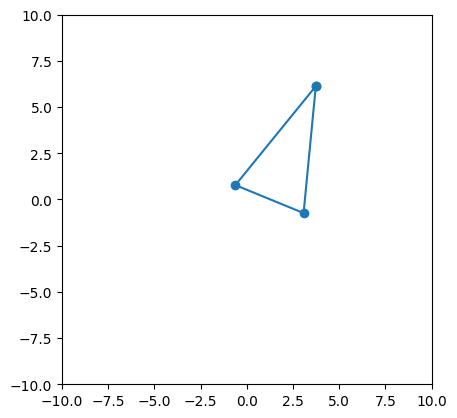

[[-4.35210916 -5.35262431]
 [ 3.69176429 -1.51435361]
 [ 0.66034486  6.86697792]]


In [305]:
def generate_random_regular_polygon(num_points, plot=False):
    # Ensure num_points is at least 3 for a valid convex hull
    num_points = max(3, num_points)
    
    # Generate random size, angle and position
    w = 0.3 + np.random.rand(1)*5
    h = 0.3 + np.random.rand(1)*5
    phi = np.random.rand(1)*2*np.pi
    pos = (np.random.rand(1) - 0.5)*2*5
    
    # Generate points
    points = np.array([[w*np.cos(alpha), h*np.sin(alpha)] for alpha in np.arange(0, 2*np.pi, 2*np.pi/num_points)])
    
    points = points.reshape((len(points), 2))
    
    rotation_matrix = np.array([[np.cos(phi), -np.sin(phi)],
                                [np.sin(phi), np.cos(phi)]]).reshape(2, 2)
    
    points = points@rotation_matrix + pos
    
    
    # Plot the convex shape
    if plot:
        plt.xlim(-10, 10)
        plt.ylim(-10, 10)

        x_list = [v[0] for v in points]
        y_list = [v[1] for v in points]
        # add the first point to close the figure
        x_list.append(points[0, 0])
        y_list.append(points[0, 1])
        plt.plot(x_list, y_list, marker = 'o')

        plt.gca().set_aspect('equal', adjustable='box')  # Equal aspect ratio
        plt.show()
    
    return points

# Example: Generate a random convex shape with exactly 5 points
shape1 = generate_random_regular_polygon(3, True)

edges = np.roll(shape1, -1, axis=0)-shape1

print(edges)

## Test with many random regular shapes

In [204]:
def testGJK_regular(seed=211, min_points=3, max_points=30, iterations_per_numbers=1000):
    np.random.seed(seed)
    
    yes = []
    no = []
    incorrect = []
    correct = []
    
    for points1 in range(min_points, max_points+1):
        for points2 in range(min_points, max_points+1):
            for i in range(iterations_per_numbers):
                
                v1 = generate_random_regular_polygon(points1)
                v2 = generate_random_regular_polygon(points2)
    
                body1 = Body(v1)
                body2 = Body(v2)
    
                p1 = Polygon(v1)
                p2 = Polygon(v2)
            
                intersects = p1.intersects(p2)
                
                if intersects:
                    yes.append([v1, v2])
                else:
                    no.append([v1, v2])
                    
                is_collision, _ = body1.check_collision_gjk(body2)
                
                if is_collision == intersects:
                    correct.append([v1, v2])
                else:
                    incorrect.append([v1, v2])
            
            w = max_points+1-min_points
            h = w
            print("progress:", 100*((points1-min_points)*w + points2-min_points)/(w*h), end="\r")
    
    return correct, incorrect, yes, no

In [86]:
correct, incorrect, yes, no = testGJK_regular()

In [87]:
print("correct:", len(correct))
print("incorrect:", len(incorrect))
print("yes:", len(yes))
print("no:", len(no))

correct: 784000
incorrect: 0
yes: 417311
no: 366689


## Handle of incorrect results

In [88]:
# Examples of incorrect
for inc in incorrect:
    b1 = Body(inc[0])
    b2 = Body(inc[1])

    Body.draw_several([b1, b2])
    plt.show()
    print(b1.check_collision_gjk(b2))

## Examples of intersections

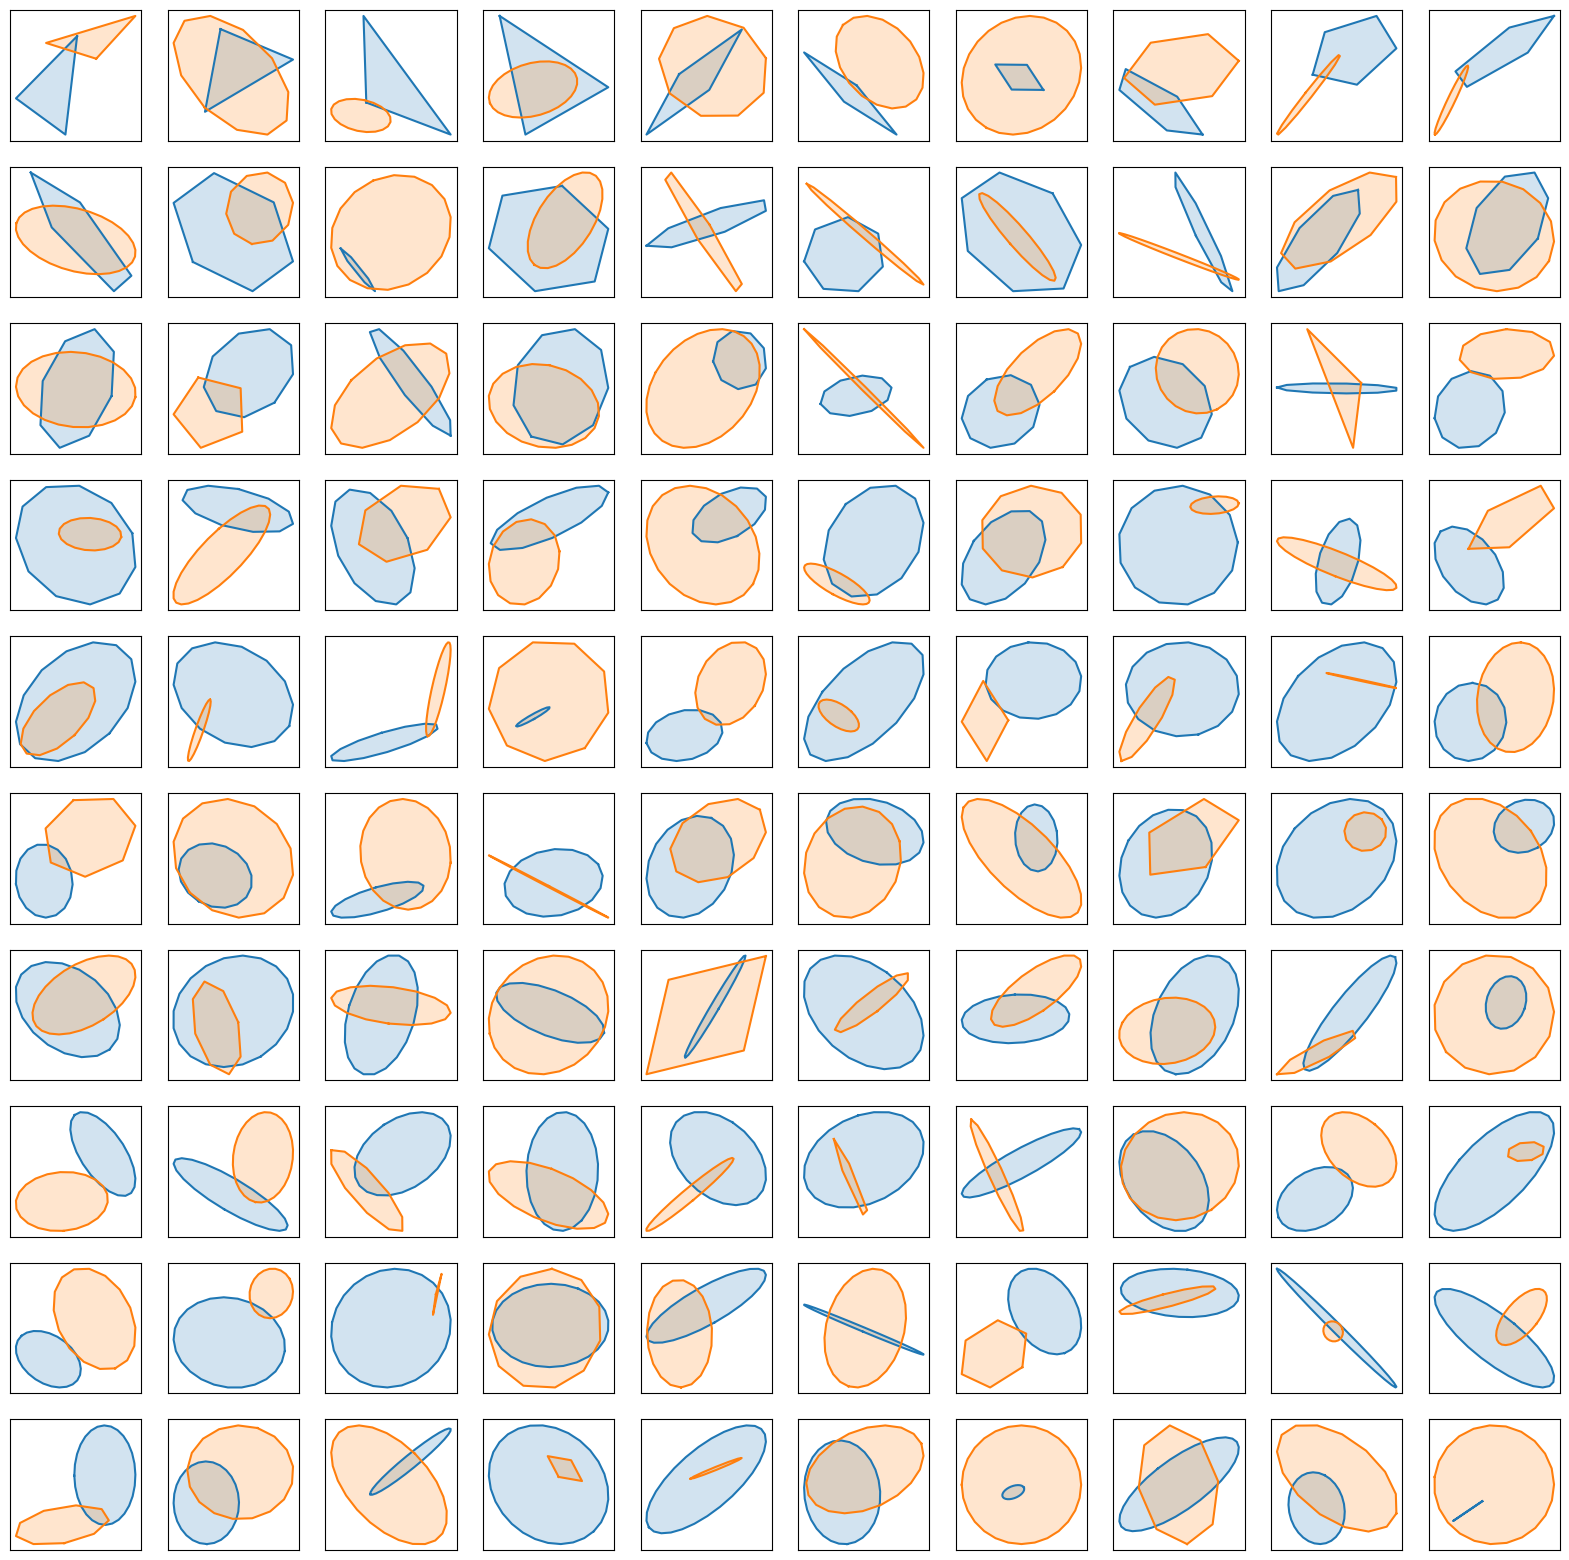

In [89]:
plt.figure(figsize=(20,20))

for i in range(100):
    
    plt.subplot(10, 10, i+1)
    
    el = int(i*len(yes)/100)
    Body.draw_several([Body(yes[el][0]), Body(yes[el][1])])
    plt.xticks([])
    plt.yticks([])

plt.savefig("plots/rand_inters_regular.pdf", format="pdf", bbox_inches="tight")
plt.show()

## Examples of no intersections

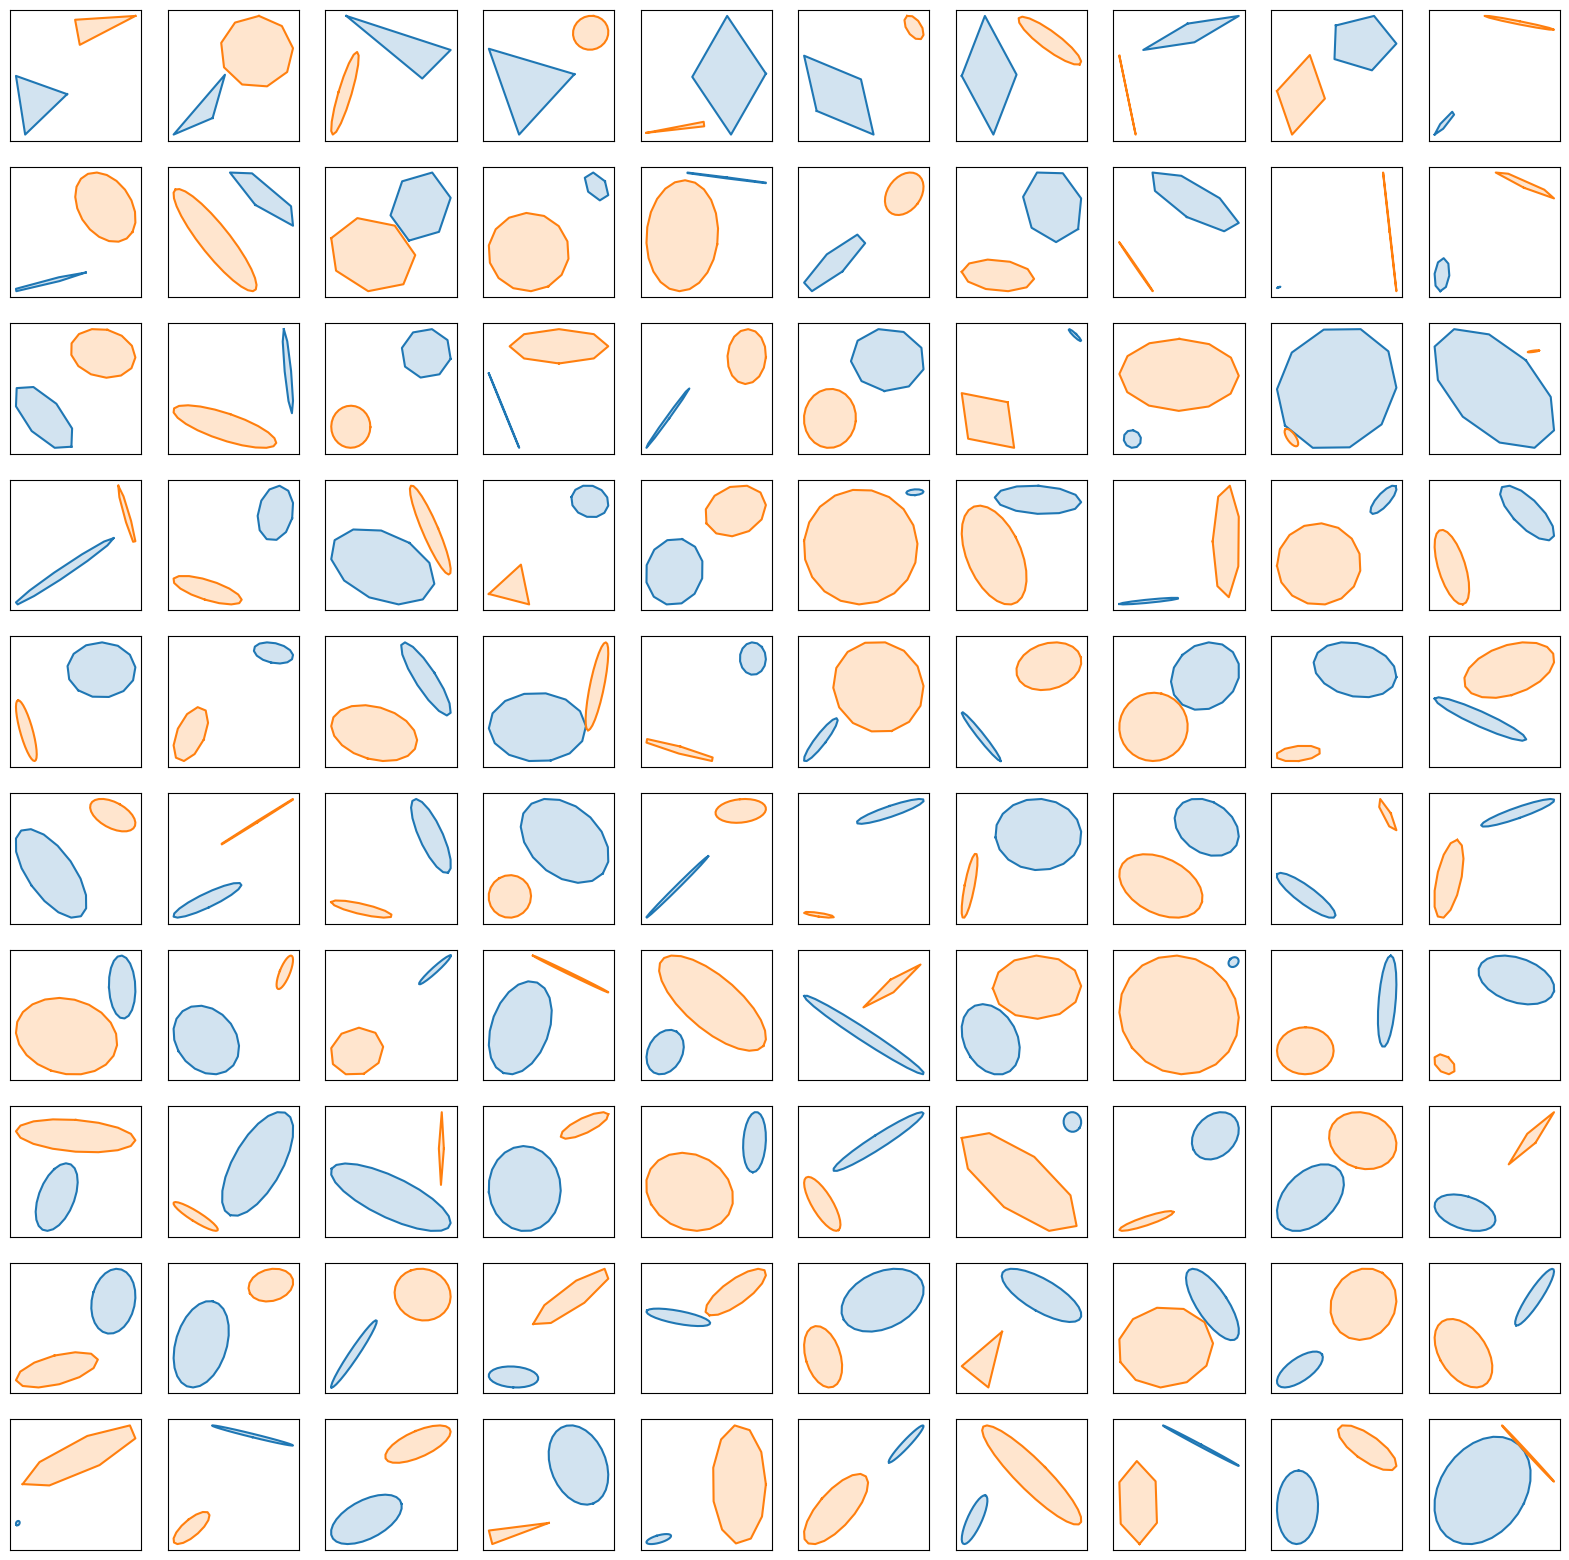

In [90]:
plt.figure(figsize=(20,20))

for i in range(100):
    
    plt.subplot(10, 10, i+1)
    
    el = int(i*len(no)/100)
    Body.draw_several([Body(no[el][0]), Body(no[el][1])])
    plt.xticks([])
    plt.yticks([])

plt.savefig("plots/rand_no_inters_regular.pdf", format="pdf", bbox_inches="tight")
plt.show()

## Time vs $n$

In [102]:
def time_vs_points1(seed=211, min_points=3, max_points=1000, iterations_per_sample=100, m=5):
    np.random.seed(seed)
    
    hist = []
    
    yes_collisions = 0
    no_collisions = 0
    
    for i in range(min_points, max_points+1):
        
        total_time = 0
        for it in range(iterations_per_sample):
            v1 = generate_random_regular_polygon(i)
            v2 = generate_random_regular_polygon(m)

            body1 = Body(v1)
            body2 = Body(v2)

            start = time.time()
            is_collision, _ = body1.check_collision_gjk(body2)
            end = time.time()
            
            total_time += end-start
            
            if is_collision:
                yes_collisions += 1
            else:
                no_collisions += 1
            
        # average the resulting time
        hist.append([i, total_time/iterations_per_sample])
        print("progress:", 100*(i-min_points)/(max_points-min_points), end="\r")
    
    print()
    print("yes:", yes_collisions)
    print("no:", no_collisions)
    
    return np.array(hist)

In [103]:
hist = time_vs_points1()

progress: 100.096990972918754
yes: 52223
no: 47577


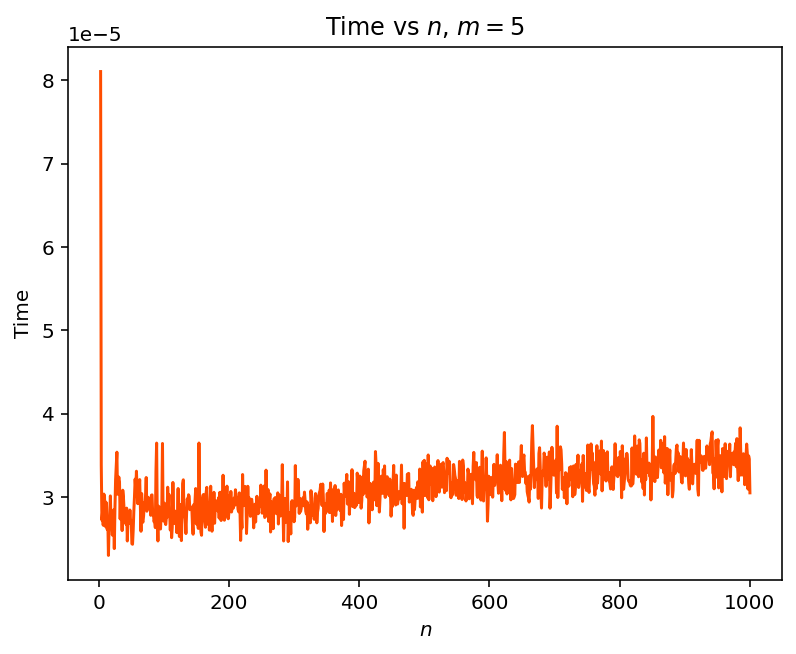

In [104]:
plt.figure('Time vs $n$', dpi=72*2)
plt.plot(hist[:, 0], hist[:, 1], c=(1, 0.3, 0))

plt.xlabel(r'$n$')
plt.ylabel('Time')
plt.title(r'Time vs $n$, $m=5$ (GJK)')

plt.savefig("plots/time_vs_n_gjk_np.pdf", format="pdf", bbox_inches="tight")

plt.show()

## Number of operations vs $n$

In [205]:
class BodyWithCount:
    def __init__(self, hitBox: np.ndarray = None):
        self.points = [] if hitBox is None else hitBox
    
    def draw(self):
        x_list = self.points[:, 0]
        y_list = self.points[:, 1]
        
        # add the first point to close the figure
        x_list = np.append(x_list, x_list[0])
        y_list = np.append(y_list, y_list[0])
        
        plt.fill_between(x_list, y_list, alpha=0.2)
        plt.plot(x_list, y_list)
        
        return x_list, y_list
    
    @staticmethod
    def draw_several(shapes):
        for shape in shapes:
            shape.draw()
    
    def size(self) -> int:
        return len(self.points)
    
    # GJK part

    def _find_furthest_point(self, direction):
        max_point = self.points[np.argmax(self.points@direction)]

        return max_point

    def _support(self, obj, direction):
        p1 = self._find_furthest_point(direction)
        p2 = obj._find_furthest_point(-direction)

        return p1 - p2
        
    @staticmethod
    def _next_simplex(simplex, count):
        simplex_type = simplex.type()

        if simplex_type == SimplexType.Line:
            return BodyWithCount._line_case(simplex, count)
        elif simplex_type == SimplexType.Triangle:
            return BodyWithCount._triangle_case(simplex, count)
        else:
            raise ValueError("Body::next_simplex: simplex is not Line or Triangle")

    @staticmethod
    def _line_case(simplex, count):
        
        new_simplex = simplex
        new_direction = 0

        a = simplex[0]
        b = simplex[1]

        ab = b - a
        ao = -a
        
        ab_n = normal_of_vector(ab)

        if ab@ao > 0:
            new_direction = ab_n if ab_n@ao > 0 else -ab_n
        else:
            new_simplex = Simplex([a])
            new_direction = ao

        return new_simplex, new_direction, False, count+1

    @staticmethod
    def _triangle_case(simplex, count):
                
        new_simplex = simplex
        new_direction = np.array([])

        a = simplex[0]
        b = simplex[1]
        c = simplex[2]

        ab = b - a
        ac = c - a
        ao = -a
        
        ac_n = normal_of_vector(ac)

        if ac_n@ao > 0:
            if ac@ao > 0:
                new_simplex = Simplex([a, c])
                new_direction = ac_n
            else:
                return BodyWithCount._line_case(Simplex([a, b]), count+1)
        else:
            if normal_of_vector(ab)@ao < 0:
                # here we need to reverse the order because we can find the next
                # point only in the direction of the -normal of AB
                return BodyWithCount._line_case(Simplex([b, a]), count+1)
            else:
                # Collision detected
                return new_simplex, new_direction, True, count+1
        
        return new_simplex, new_direction, False, count+1

    def check_collision_gjk(self, obj):
        
        count = 0
        
        # Get initial support point in any direction
        support = self._support(obj, np.array([1, 0]))
        count += self.size() + obj.size()
        
        # Simplex is an array of points, max count is 4
        simplex = Simplex()
        simplex.push_front(support)

        # New direction is towards the origin
        direction = -support

        iters = 0
        while iters < self.size() + obj.size():
            iters += 1
            support = self._support(obj, direction)
            count += self.size() + obj.size()
            
            if support@direction <= 0:
                return False, simplex, count  # no collision

            simplex.push_front(support)

            new_simplex, new_direction, is_found, count = BodyWithCount._next_simplex(simplex, count)

            direction = new_direction
            simplex = new_simplex
            
            if is_found:
                return True, simplex, count
        

        return False, simplex, count

In [206]:
def test_collision_count(x_shift=2.40, y_shift=-0.30):
    body2 = BodyWithCount([Vec2D(-1+x_shift, -1+y_shift), Vec2D(0+x_shift, 1+y_shift), Vec2D(1+x_shift, -1+y_shift)])
    body1 = BodyWithCount([Vec2D(-1, -1), Vec2D(0, 1), Vec2D(1, 1), Vec2D(2, -1)])
    
    plt.xlim(-10, 10)
    plt.ylim(-10, 10)
    BodyWithCount.draw_several([body1, body2])
    
    is_collision, _, count = body1.check_collision_gjk(body2)
    print("Collision =", is_collision)
    print("Steps =", count)
    
# simple example with trangle and parallelogram 
#widgets.interact(test_collision_count, x_shift=(-3.0, 3.0, 0.3), y_shift=(-3.0, 3.0, 0.3))

In [207]:
def steps_vs_points1(seed=211, min_points=3, max_points=1000, iterations_per_sample=100, m=5):
    np.random.seed(seed)
    
    hist = []
    
    yes_collisions = 0
    no_collisions = 0
    
    for i in range(min_points, max_points+1):
        
        total_counter = 0
        for it in range(iterations_per_sample):
            v1 = generate_random_regular_polygon(i)
            v2 = generate_random_regular_polygon(m)

            body1 = BodyWithCount(v1)
            body2 = BodyWithCount(v2)

            is_collision, _, count = body1.check_collision_gjk(body2)
            
            total_counter += count
            
            if is_collision:
                yes_collisions += 1
            else:
                no_collisions += 1
            
        # average the resulting time
        hist.append([i, total_counter/iterations_per_sample])
        print("progress:", 100*(i-min_points)/(max_points-min_points), end="\r")
    
    print()
    print("yes:", yes_collisions)
    print("no:", no_collisions)
    
    return np.array(hist)

In [97]:
hist = steps_vs_points1()

progress: 100.096990972918754
yes: 52223
no: 47577


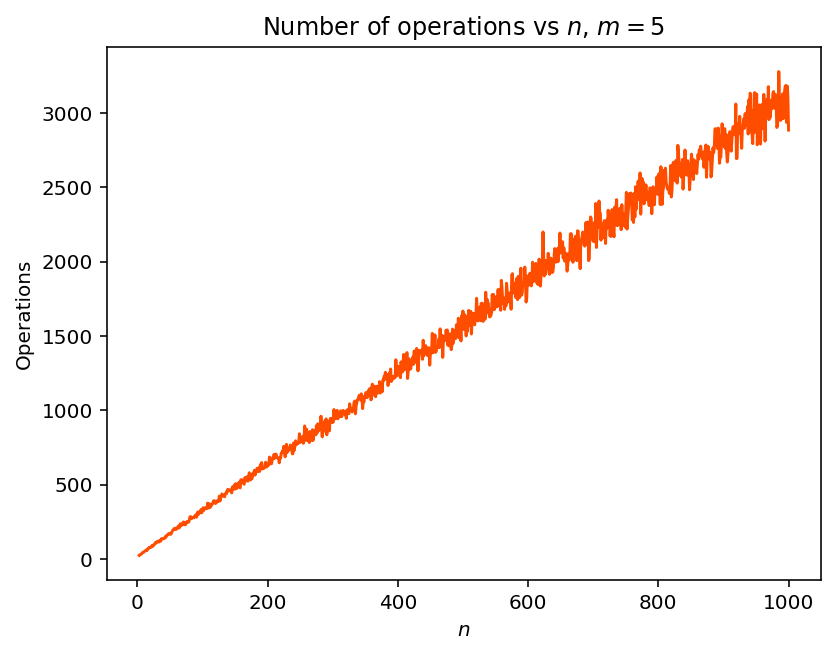

In [98]:
plt.figure('Number of operations vs $n$', dpi=72*2)
plt.plot(hist[:, 0], hist[:, 1], c=(1, 0.3, 0))

plt.xlabel(r'$n$')
plt.ylabel('Operations')
plt.title(r'Number of operations vs $n$, $m=5$ (GJK)')

plt.show()

In [99]:
A = np.column_stack((hist[:, 0], np.ones(len(hist))))
ATA = A.T@A
y = hist[:, 1]

l = la.inv(ATA)@A.T@y

In [100]:
X = [i for i in range(int(hist[-1, 0]))]
Y = [l[0]*x + l[1] for x in X]

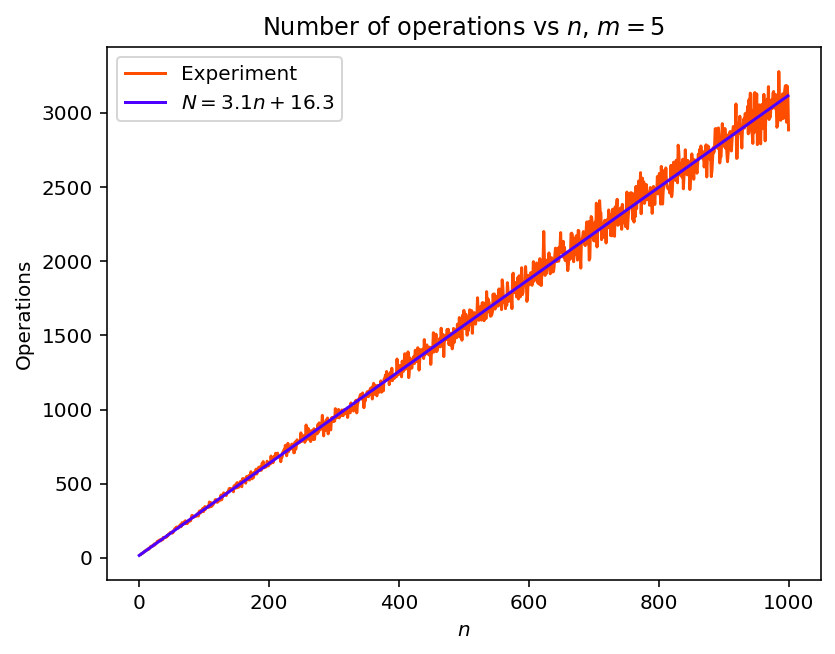

In [101]:
plt.figure('Number of operations vs $n$', dpi=72*2)
plt.plot(hist[:, 0], hist[:, 1], c=(1, 0.3, 0), label="Experiment")
plt.plot(X, Y, c=(0.3, 0, 1), label=r"$N="+str(round(l[0], 2))+"n + " + str(round(l[1], 2)) + "$")

plt.xlabel(r'$n$')
plt.ylabel('Operations')
plt.title(r'Number of operations vs $n$, $m=5$ (GJK)')

plt.legend()

plt.savefig("plots/steps_vs_n_1000_100_gjk_np.pdf", format="pdf", bbox_inches="tight")

plt.show()

# Implementation of SAT

[Proof of SAT](https://math.stackexchange.com/questions/2106402/proof-of-separating-axis-theorem-for-polygons)

In [322]:
class BodySAT:
    def __init__(self, hitBox: np.ndarray = None):
        self.points = [] if hitBox is None else hitBox
    
    def draw(self):
        x_list = self.points[:, 0]
        y_list = self.points[:, 1]
        
        # add the first point to close the figure
        x_list = np.append(x_list, x_list[0])
        y_list = np.append(y_list, y_list[0])
        
        plt.fill_between(x_list, y_list, alpha=0.2)
        plt.plot(x_list, y_list)
        
        return x_list, y_list
    
    @staticmethod
    def draw_several(shapes):
        for shape in shapes:
            shape.draw()
    
    def size(self) -> int:
        return len(self.points)
    
    
    # SAT part
    def project_onto_axis(self, axis):
        # Project points onto the given axis
        projections = self.points@axis        
        return np.min(projections), np.max(projections)

    def check_collision_sat(self, shape2):
        
        def get_normals(vertices):
            # Calculate the normals of the edges of the shape
            edges = np.roll(vertices, -1, axis=0)-vertices
            normals = np.array([[-edge[1], edge[0]] for edge in edges])
            return normals / np.linalg.norm(normals, axis=1, keepdims=True)
        
        def is_separating_axis(axis):
            # Check if the axis is a separating axis
            min1, max1 = self.project_onto_axis(axis)
            min2, max2 = shape2.project_onto_axis(axis)
            return max1 < min2 or max2 < min1

        # Get normals for both shapes
        normals1 = get_normals(self.points)
        normals2 = get_normals(shape2.points)
        
        # Check normals of the first shape
        for normal in normals1:
            # if we can find such a plane -> there is no collision
            if is_separating_axis(normal):
                return False

        # Check normals of the second shape
        for normal in normals2:
            # if we can find such a plane -> there is no collision
            if is_separating_axis(normal):
                return False

        # if we cannot find such a plane -> there is a collision
        return True

## Test with many random shapes

In [209]:
def testSAT(seed=211, min_points=3, max_points=10, iterations_per_numbers=1000):
    np.random.seed(seed)
    
    yes = []
    no = []
    incorrect = []
    correct = []
    
    for points1 in range(min_points, max_points+1):
        for points2 in range(min_points, max_points+1):
            for i in range(iterations_per_numbers):
                
                v1 = generate_random_convex_shape(points1)
                v2 = generate_random_convex_shape(points2)
    
                body1 = BodySAT(v1)
                body2 = BodySAT(v2)
    
                p1 = Polygon(v1)
                p2 = Polygon(v2)
            
                intersects = p1.intersects(p2)
                
                if intersects:
                    yes.append([v1, v2])
                else:
                    no.append([v1, v2])
                    
                is_collision = body1.check_collision_sat(body2)
                
                if is_collision == intersects:
                    correct.append([v1, v2])
                else:
                    incorrect.append([v1, v2])
            
            w = max_points+1-min_points
            h = w
            print("progress:", 100*((points1-min_points)*w + points2-min_points)/(w*h), end="\r")
    
    return correct, incorrect, yes, no

In [155]:
correct, incorrect, yes, no = testSAT()

In [156]:
print("correct:", len(correct))
print("incorrect:", len(incorrect))
print("yes:", len(yes))
print("no:", len(no))

correct: 64000
incorrect: 0
yes: 34610
no: 29390


## Test with many random regular shapes

In [157]:
def testSAT_regular(seed=211, min_points=3, max_points=30, iterations_per_numbers=1000):
    np.random.seed(seed)
    
    yes = []
    no = []
    incorrect = []
    correct = []
    
    for points1 in range(min_points, max_points+1):
        for points2 in range(min_points, max_points+1):
            for i in range(iterations_per_numbers):
                
                v1 = generate_random_regular_polygon(points1)
                v2 = generate_random_regular_polygon(points2)
    
                body1 = BodySAT(v1)
                body2 = BodySAT(v2)
    
                p1 = Polygon(v1)
                p2 = Polygon(v2)
            
                intersects = p1.intersects(p2)
                
                if intersects:
                    yes.append([v1, v2])
                else:
                    no.append([v1, v2])
                    
                is_collision = body1.check_collision_sat(body2)
                
                if is_collision == intersects:
                    correct.append([v1, v2])
                else:
                    incorrect.append([v1, v2])
            
            w = max_points+1-min_points
            h = w
            print("progress:", 100*((points1-min_points)*w + points2-min_points)/(w*h), end="\r")
    
    return correct, incorrect, yes, no

In [314]:
correct, incorrect, yes, no = testSAT_regular()

KeyboardInterrupt: 

In [159]:
print("correct:", len(correct))
print("incorrect:", len(incorrect))
print("yes:", len(yes))
print("no:", len(no))

correct: 784000
incorrect: 0
yes: 417311
no: 366689


## Handle of incorrect results

In [160]:
# Examples of incorrect
for inc in incorrect:
    b1 = BodySAT(inc[0])
    b2 = BodySAT(inc[1])

    Body.draw_several([b1, b2])
    plt.show()
    print(b1.check_collision_sat(b2))

## Time vs $n$

In [315]:
def time_vs_points1(seed=211, min_points=3, max_points=1000, iterations_per_sample=100, m=5):
    np.random.seed(seed)
    
    hist = []
    
    yes_collisions = 0
    no_collisions = 0
    
    for i in range(min_points, max_points+1):
        
        total_time = 0
        for it in range(iterations_per_sample):
            v1 = generate_random_regular_polygon(i)
            v2 = generate_random_regular_polygon(m)

            body1 = BodySAT(v1)
            body2 = BodySAT(v2)

            start = time.time()
            is_collision = body1.check_collision_sat(body2)
            end = time.time()
            
            total_time += end-start
            
            if is_collision:
                yes_collisions += 1
            else:
                no_collisions += 1
            
        # average the resulting time
        hist.append([i, total_time/iterations_per_sample])
        print("progress:", 100*(i-min_points)/(max_points-min_points), end="\r")
    
    print()
    print("yes:", yes_collisions)
    print("no:", no_collisions)
    
    return np.array(hist)

In [316]:
hist = time_vs_points1()

/var/folders/2t/kz1d66l93z5fpjknlxt9tl7wb_bw5m/T/ipykernel_27312/3881195565.py:41: RuntimeWarning: invalid value encountered in divide
  return normals / np.linalg.norm(normals, axis=1, keepdims=True)


progress: 100.09699097291875
yes: 57672
no: 42128


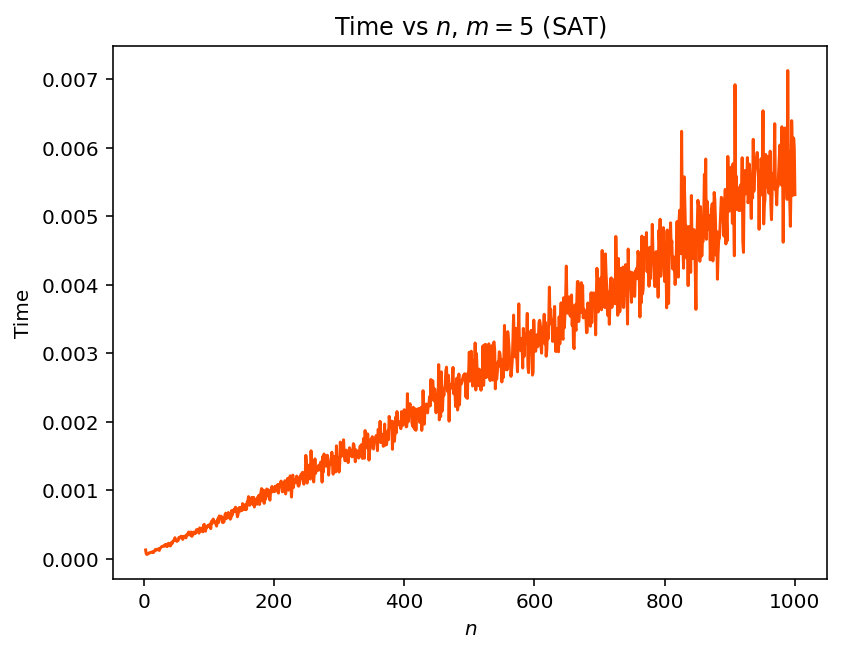

In [317]:
plt.figure('Time vs $n$ (SAT)', dpi=72*2)
plt.plot(hist[:, 0], hist[:, 1], c=(1, 0.3, 0))

plt.xlabel(r'$n$')
plt.ylabel('Time')
plt.title(r'Time vs $n$, $m=5$ (SAT)')

plt.savefig("plots/time_vs_n_sat_np.pdf", format="pdf", bbox_inches="tight")

plt.show()

## Number of operations vs $n$

In [323]:
class BodySATWithCount:
    def __init__(self, hitBox: np.ndarray = None):
        self.points = [] if hitBox is None else hitBox
    
    def draw(self):
        x_list = self.points[:, 0]
        y_list = self.points[:, 1]
        
        # add the first point to close the figure
        x_list = np.append(x_list, x_list[0])
        y_list = np.append(y_list, y_list[0])
        
        plt.fill_between(x_list, y_list, alpha=0.2)
        plt.plot(x_list, y_list)
        
        return x_list, y_list
    
    @staticmethod
    def draw_several(shapes):
        for shape in shapes:
            shape.draw()
    
    def size(self) -> int:
        return len(self.points)
    
    # SAT part
    def project_onto_axis(self, axis):
        # Project points onto the given axis
        projections = self.points@axis        
        return np.min(projections), np.max(projections)

    def check_collision_sat(self, shape2):
        
        count = 0
        
        def get_normals(vertices):
            # Calculate the normals of the edges of the shape
            edges = np.roll(vertices, -1, axis=0)-vertices
            normals = np.array([[-edge[1], edge[0]] for edge in edges])
            return normals / np.linalg.norm(normals, axis=1, keepdims=True)
        
        def is_separating_axis(axis):
            # Check if the axis is a separating axis
            min1, max1 = self.project_onto_axis(axis)
            min2, max2 = shape2.project_onto_axis(axis)
            return max1 < min2 or max2 < min1

        # Get normals for both shapes
        normals1 = get_normals(self.points)
        normals2 = get_normals(shape2.points)
        
        count += self.size() + shape2.size()
        
        # Check normals of the first shape
        for normal in normals1:
            # if we can find such a plane -> there is no collision
            count += self.size() + shape2.size()
            if is_separating_axis(normal):
                return False, count

        # Check normals of the second shape
        for normal in normals2:
            # if we can find such a plane -> there is no collision
            count += self.size() + shape2.size()
            if is_separating_axis(normal):
                return False, count

        # if we cannot find such a plane -> there is a collision
        return True, count

In [324]:
def steps_vs_points1(seed=221, min_points=3, max_points=1000, iterations_per_sample=100, m=5):
    np.random.seed(seed)
    
    hist = []
    
    yes_collisions = 0
    no_collisions = 0
    
    for i in range(min_points, max_points+1):
        
        total_counter = 0
        for it in range(iterations_per_sample):
            v1 = generate_random_regular_polygon(i)
            v2 = generate_random_regular_polygon(m)

            body1 = BodySATWithCount(v1)
            body2 = BodySATWithCount(v2)

            is_collision, count = body1.check_collision_sat(body2)
            
            total_counter += count
            
            if is_collision:
                yes_collisions += 1
            else:
                no_collisions += 1
            
        # average the resulting time
        hist.append([i, total_counter/iterations_per_sample])
        print("progress:", 100*(i-min_points)/(max_points-min_points), end="\r")
    
    print()
    print("yes:", yes_collisions)
    print("no:", no_collisions)
    
    return np.array(hist)

In [325]:
hist = steps_vs_points1()

/var/folders/2t/kz1d66l93z5fpjknlxt9tl7wb_bw5m/T/ipykernel_27312/3119820852.py:40: RuntimeWarning: invalid value encountered in divide
  return normals / np.linalg.norm(normals, axis=1, keepdims=True)


progress: 100.09699097291875
yes: 57866
no: 41934


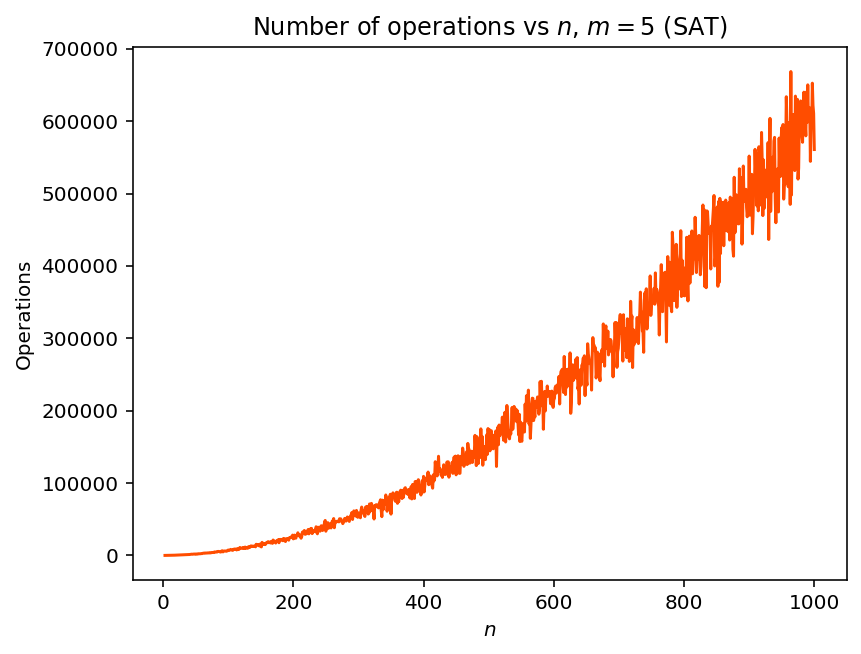

In [326]:
plt.figure('Number of operations vs $n$', dpi=72*2)
plt.plot(hist[:, 0], hist[:, 1], c=(1, 0.3, 0))

plt.xlabel(r'$n$')
plt.ylabel('Operations')
plt.title(r'Number of operations vs $n$, $m=5$ (SAT)')

plt.show()

In [327]:
A = np.column_stack((hist[:, 0]**2, hist[:, 0], np.ones(len(hist))))
ATA = A.T@A
y = hist[:, 1]

l = la.inv(ATA)@A.T@y

In [328]:
X = [i for i in range(int(hist[-1, 0]))]
Y = [l[0]*x**2 + l[1]*x + l[2] for x in X]

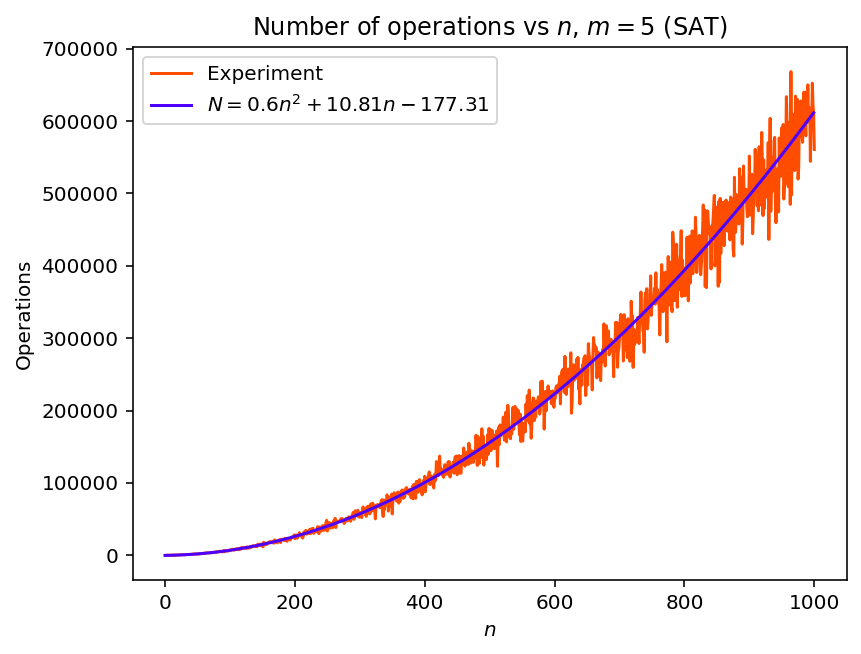

In [329]:
plt.figure('Number of operations vs $n$ (SAT)', dpi=72*2)
plt.plot(hist[:, 0], hist[:, 1], c=(1, 0.3, 0), label="Experiment")
plt.plot(X, Y, c=(0.3, 0, 1), label=r"$N="+str(round(l[0], 2))+"n^2 + " + str(round(l[1], 2)) + "n " + str(round(l[2], 2)) + "$")

plt.xlabel(r'$n$')
plt.ylabel('Operations')
plt.title(r'Number of operations vs $n$, $m=5$ (SAT)')

plt.legend()

plt.savefig("plots/steps_vs_n_1000_100_sat_np.pdf", format="pdf", bbox_inches="tight")

plt.show()